In [1]:
import datetime as dt
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [2]:
# data directory
DATA_DIR = '../Input_processed_data'

# IC, 道路情報 csv
IC_CSV = f'{DATA_DIR}/road_master/ic_merged.csv'
IC_NET_CSV = f'{DATA_DIR}/road_master/tateyama_kannetsu_doronet_sub_with_rule.csv'

# 検索ログ csv
SEARCH_LOG_DIR = lambda month: f'{DATA_DIR}/search_records/csv{month}'
SEARCH_LOG_CSV = lambda date: f'{SEARCH_LOG_DIR(date[:6])}/record_{date}.csv'

# 検索件数 csv
SEARCH_COUNT_TATEYAMA_CSV = f'{DATA_DIR}/search_count/tateyama_spec.csv'
SEARCH_COUNT_KANNETSU_CSV = f'{DATA_DIR}/search_count/kannetsu_spec.csv'

UNSPECIFIED_SEARCH_COUNT_TATEYAMA_CSV = f'{DATA_DIR}/search_count/tateyama_unspec.csv'
UNSPECIFIED_SEARCH_COUNT_KANNETSU_CSV = f'{DATA_DIR}/search_count/kannetsu_unspec.csv'

# 交通量 csv
TRAFFIC_TATEYAMA_CSV = f'{DATA_DIR}/traffic/tateyama_202104~202205all-merged_filled.csv'
TRAFFIC_KANNETSU_CSV = f'{DATA_DIR}/traffic/kannetsu_202104~202205all-merged_filled.csv'

In [3]:
# モジュール内で前処理済み
df_ic = pd.read_csv(IC_CSV, dtype={'ic_code': str})
code2name = dict(zip(df_ic['ic_code'], df_ic['ic_name']))
name2code = {v: k for k, v in code2name.items()}

df_icnet = pd.read_csv(IC_NET_CSV, dtype={'start_code': str, 'end_code': str, 'road_code': str})
ic_graph = nx.from_pandas_edgelist(df_icnet, source='start_code', target='end_code',
                                  edge_attr=['road_code', 'direction'],
                                  create_using=nx.DiGraph())

In [5]:
df_tateyama = pd.read_csv(TRAFFIC_TATEYAMA_CSV, index_col='datetime', parse_dates=True, 
                                  dtype={'start_code': str, 'end_code': str, 'road_code': str}).reset_index()

df_kannetsu = pd.read_csv(TRAFFIC_KANNETSU_CSV, index_col='datetime', parse_dates=True, 
                                  dtype={'start_code': str, 'end_code': str, 'road_code': str}).reset_index()

/tmp/ipykernel_1412399/2240595943.py:1: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tateyama = pd.read_csv(TRAFFIC_TATEYAMA_CSV, index_col='datetime', parse_dates=True,
/tmp/ipykernel_1412399/2240595943.py:4: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_kannetsu = pd.read_csv(TRAFFIC_KANNETSU_CSV, index_col='datetime', parse_dates=True,


In [72]:
df_tateyama.replace('1130039', '1130036', inplace=True)
df_kannetsu.replace({'1800146': '1800151', '1800072': '1800073'}, inplace=True)

In [15]:
df_ic = pd.read_csv(IC_CSV, dtype={'ic_code': str})
code2name = dict(zip(df_ic['ic_code'], df_ic['ic_name']))
name2code = {v: k for k, v in code2name.items()}

In [14]:
net_cols = ['start_code', 'end_code', 'road_code', 'distance', 'direction']

tateyama_net = df_tateyama.drop_duplicates(['start_code', 'end_code']).loc[:, net_cols]
kannetsu_net = df_kannetsu.drop_duplicates(['start_code', 'end_code']).loc[:, net_cols]

df_icnet = pd.concat([tateyama_net, kannetsu_net])
df_icnet.replace({'1130039': '1130036', '1800146': '1800151', '1800072': '1800073'}, inplace=True)

ic_graph = nx.from_pandas_edgelist(df_icnet, source='start_code', target='end_code',
                                  edge_attr=['road_code', 'direction'],
                                  create_using=nx.DiGraph())

In [22]:
df_tateyama['speed'].fillna(method='ffill', inplace=True)
df_kannetsu['speed'].fillna(method='ffill', inplace=True)

In [73]:
tat = df_tateyama
kan = df_kannetsu

## 時間指定ありデータ

### 可視化・分析

In [24]:
tat.filter(like='search').describe()

,search_5min,search_1h,search_unspec_1d,search_unspec_3d,search_unspec_7d,search_unspec_10d
count,1.856302e+06,1.856302e+06,1.852416e+06,1.852416e+06,1.852416e+06,1.852416e+06
mean,2.205778e-01,2.424795e+00,3.736774e+02,1.117417e+03,2.586913e+03,3.672114e+03
std,9.345086e-01,5.349225e+00,2.453510e+02,7.053045e+02,1.603433e+03,2.264080e+03
min,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00,5.000000e+00
25%,0.000000e+00,0.000000e+00,1.720000e+02,5.227500e+02,1.200750e+03,1.692500e+03
50%,0.000000e+00,0.000000e+00,3.790000e+02,1.140000e+03,2.671000e+03,3.807500e+03
75%,0.000000e+00,3.000000e+00,5.240000e+02,1.574000e+03,3.666000e+03,5.239000e+03
max,6.400000e+01,1.770000e+02,3.643000e+03,5.093000e+03,1.022900e+04,1.284600e+04


In [25]:
kan.filter(like='search').describe()

,search_5min,search_1h,search_unspec_1d,search_unspec_3d,search_unspec_7d,search_unspec_10d
count,7.305576e+06,7.305576e+06,7.293888e+06,7.293888e+06,7.293888e+06,7.293888e+06
mean,2.445165e+00,2.677497e+01,2.490938e+03,7.450149e+03,1.725338e+04,2.448974e+04
std,5.807639e+00,5.580481e+01,1.807698e+03,5.371834e+03,1.238928e+04,1.756219e+04
min,0.000000e+00,0.000000e+00,3.070000e+02,7.050000e+02,7.050000e+02,7.050000e+02
25%,0.000000e+00,4.000000e+00,1.052000e+03,3.146000e+03,7.302000e+03,1.035500e+04
50%,0.000000e+00,1.100000e+01,1.983000e+03,5.939500e+03,1.381000e+04,1.965750e+04
75%,3.000000e+00,2.700000e+01,3.340000e+03,9.959000e+03,2.298500e+04,3.264100e+04
max,2.610000e+02,1.455000e+03,1.279400e+04,3.373000e+04,6.919300e+04,9.069400e+04


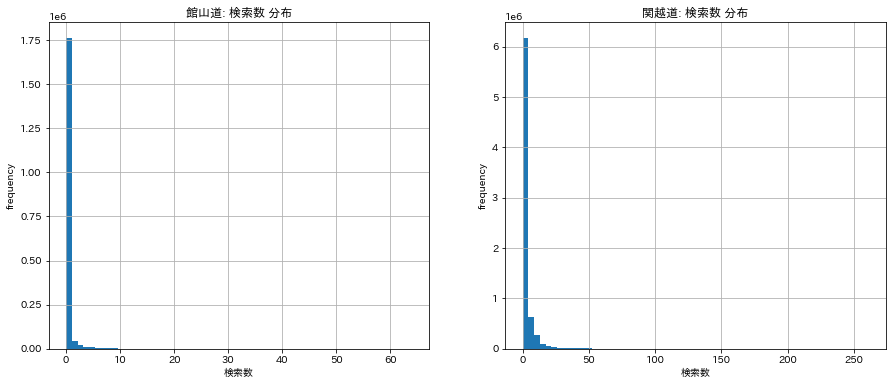

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(tat['search_5min'], bins=60)
axes[0].set_xlabel('検索数')
axes[0].set_ylabel('frequency')
axes[0].set_title('館山道: 検索数 分布')
axes[0].grid()

axes[1].hist(kan['search_5min'], bins=60)
axes[1].set_xlabel('検索数')
axes[1].set_ylabel('frequency')
axes[1].set_title('関越道: 検索数 分布')
axes[1].grid()

plt.show()

### ヒートマップ

#### 準備

In [19]:
def get_road_graph(df, road_code, direction='down'):
    '''
    特定の路線上のICのみから構成されるグラフを取得する関数
    （後のヒートマップによる可視化のために一直線のグラフを構築したい 
    → 上り・下りの違いで分岐が発生する路線（e.g. 東北道）が存在するためdirectionを指定する）

    Parameters
    --------------
    df: pandas.DataFrame
    ICの接続関係が格納されたデータフレーム
    road_code: str
    指定したい路線コード
    direction: {"down", "up"}
    上りか下りか

    Returns
    ----------
    road_graph: nx.DiGraph
    指定された路線上, 指定された方向のICのグラフ
    '''
    # 引数で指定した特定路線についての接続関係のみを抽出
    df = df[df['road_code'] == road_code]

    # ICグラフを構築
    road_graph = nx.from_pandas_edgelist(df, source='start_code', target='end_code',
                                      edge_attr=['direction'],
                                      create_using=nx.DiGraph())

    # 「上り or 下り」によってエッジの向きを変更
    # （これは後に路線上のICの順番をグラフから正しく取り出せるようにするための処理）
    if direction == 'down':
        sub_list = [(s, t, attr) for s, t, attr in road_graph.edges(data=True) if attr['direction'] == '下り']
    elif direction == 'up':
        sub_list = [(t, s, attr) for s, t, attr in road_graph.edges(data=True) if attr['direction'] == '上り']
    else:
        assert False, 'direction should be either down or up'
  
    # 路線, 方向（上り, 下り）が限定されたICのグラフを構築
    road_graph = nx.DiGraph()
    road_graph.add_edges_from(sub_list)

    return road_graph


def get_ic_order(df, road_code, direction='down'):
    '''
    特定路線上のICの順番をDict形式で取得する関数

    Parameters
    --------------
    df: pandas.DataFrame
    ICグラフの元になる接続関係データ
    road_code: str
    指定したい路線コード
    direction: {"down", "up"}
    上りか下りか

    Returns
    ----------
    ic_order_map: Dict[str, int]
    ICコード => 順番のマップ
    '''
    # 特定路線, 特定方向のICグラフを構築
    road_graph = get_road_graph(df, road_code, direction)

    # グラフのtraverseによって各ノード(IC)の順番を取得
    if direction == 'down':
        nodes = nx.dfs_postorder_nodes(road_graph)
        nodes = list(nodes)[::-1]
    elif direction == 'up':
        nodes = nx.dfs_postorder_nodes(road_graph)
    else:
        assert False, 'direction should be either down or up'
  
    ic_order_map = {code: i for i, code in enumerate(nodes)}

    return ic_order_map

In [27]:
order_tateyama = {
    'down': get_ic_order(df_icnet, '1130', direction='down'),
    'up': get_ic_order(df_icnet, '1130', direction='up')
}

order_kannetsu = {
    'down': get_ic_order(df_icnet, '1800', direction='down'),
    'up': get_ic_order(df_icnet, '1800', direction='up')
}

In [31]:
def max_min(mat, axis=0):
    min = mat.min(axis=axis, keepdims=True)
    max = mat.max(axis=axis, keepdims=True)
    return (mat - min) / (max - min)


def zscore(mat, axis=0):
    m = mat.mean(axis=axis, keepdims=True)
    s = mat.std(axis=axis, keepdims=True)
    return (mat - m) / s

In [20]:
def init_congmat(sr, start, end=None, road_code='1130'):
    if sr[-1] == 'd':
        dt_format = '%Y-%m-%d'
        ts = [d.strftime(dt_format) for d in pd.date_range(start, end, freq=sr)]
    elif sr[-1] == 'h':
        dt_format = '%Y-%m-%d %H:%M'
        ts = [t.strftime(dt_format) for t in pd.date_range(start, periods=24 / int(sr[:-1]), freq=sr)]
    elif sr[-3:] == 'min':
        dt_format = '%Y-%m-%d %H:%M'
        ts = [t.strftime(dt_format) for t in pd.date_range(start, periods=24* (60 / int(sr[:-3])), freq=sr)]
    else:
        assert False, 'sr must be {1d, 1h, 5min}'

    n_ts = len(ts)

    if road_code == '1130':
        n_nodes_down = len(order_tateyama['down'])
        n_nodes_up = len(order_tateyama['up'])
    elif road_code == '1800':
        n_nodes_down = len(order_kannetsu['down'])
        n_nodes_up = len(order_kannetsu['up'])
    else:
        assert False, 'road_code must be {1130, 1800}'
  
    cong_mat_down = np.zeros((n_ts, n_nodes_down-1), dtype=int)
    cong_mat_up = np.zeros((n_ts, n_nodes_up-1), dtype=int)

    return cong_mat_down, cong_mat_up, ts


def get_congmat(df, sr, start, end=None, road_code='1130', time_col='datetime', num_col='allCars'):
    def f(arr, mat_down, mat_up, ic_order, ts_map):
        t = arr[time_col].strftime('%Y-%m-%d')
        if t not in ts_map:
            t = arr[time_col].strftime('%Y-%m-%d %H:%M')
        if t not in ts_map:
            return False

        start, end, n = arr[['start_code', 'end_code', num_col]]

        if ic_graph[start][end]['direction'] == '下り':
            ind = ic_order['down'][start]
            mat_down[ts_map[t], ind] = n
        else:
            ind = ic_order['up'][start]
            mat_up[ts_map[t], ind] = n

        return True

    if road_code == '1130':
        order = order_tateyama
    elif road_code == '1800':
        order = order_kannetsu
    else:
        assert False, 'road_code must be {1130, 1800}'

    mat_d, mat_u, ts = init_congmat(sr, start, end, road_code)

    ts_map = {t: i for i, t in enumerate(ts)}

    df.apply(f, axis=1, args=[mat_d, mat_u, order, ts_map])

    return mat_d, mat_u, ts

In [77]:
def plot_heatmap(mat, xlabel, ylabel, title, xticklabels, yticklabels, ax, fontdict_x={}, fontdict_y={}):
    xticks = range(len(xticklabels))
    yticks = range(0, mat.shape[0], 12)

    ## plot ##
    # fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
    sns.heatmap(mat, cmap='Oranges', linewidth=0.2, cbar=False, ax=ax)

    ## config ##
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_title(title, fontsize=20)

    ax.set_xticks(xticks)
    fontdict_x.update({
        'fontsize': 12,
        'horizontalalignment': 'right',
    })
    ax.set_xticklabels(labels=xticklabels, fontdict=fontdict_x, rotation=60)

    ax.set_yticks(ticks=yticks)
    fontdict_y.update({
        'fontsize': 14,
        'verticalalignment': 'center_baseline',
    })
    ax.set_yticklabels(labels=yticklabels, fontdict=fontdict_y, rotation=360)

    # plt.show()

#### 2022/4/29 - 2022/5/8

In [67]:
tat_1d = resample_search(tat_1h, '1d')
kan_1d = resample_search(kan_1h, '1d')

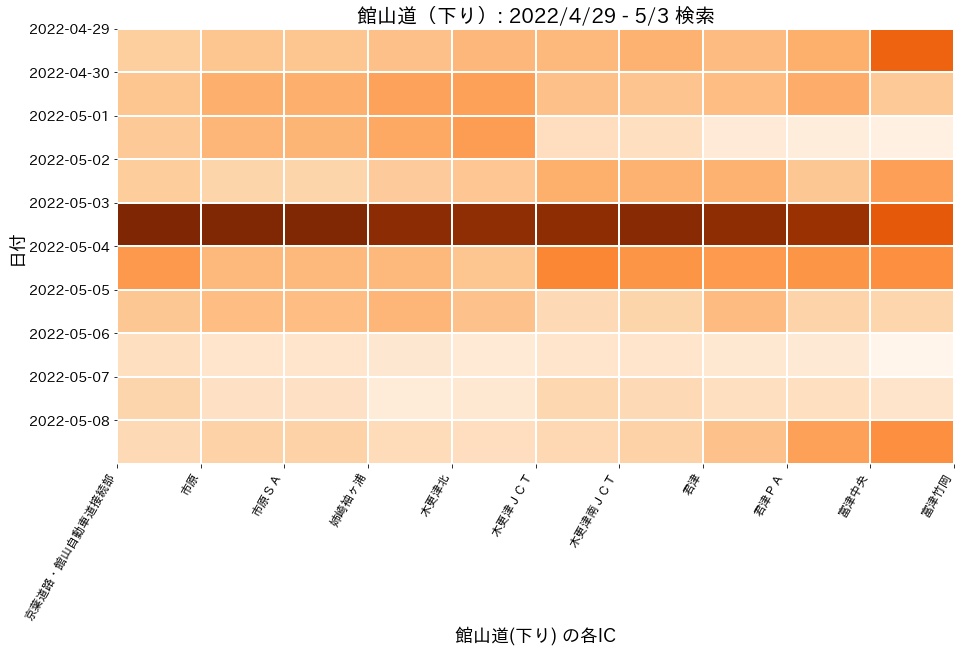

In [89]:
tat_down, tat_up, ts = get_congmat(tat_1d, '1d', '20220429', '20220508', road_code='1130')

values = zscore(tat_down, axis=0)

xlabel = '館山道(下り) の各IC'
ylabel = '日付'
title = '館山道（下り）: 2022/4/29 - 5/3 検索'

xticklabels = [code2name[c] for c in order_tateyama['down'].keys()]
yticklabels = ts

fig, ax = plt.subplots(1,1, figsize=(15,8))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

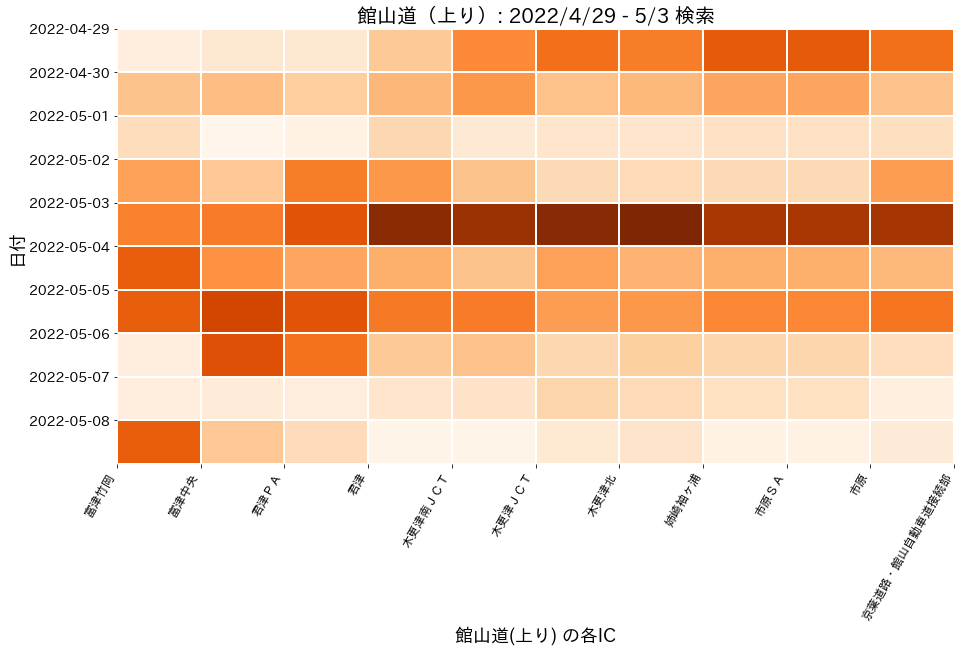

In [90]:
values = zscore(tat_up, axis=0)

xlabel = '館山道(上り) の各IC'
ylabel = '日付'
title = '館山道（上り）: 2022/4/29 - 5/3 検索'

xticklabels = [code2name[c] for c in order_tateyama['up'].keys()]
yticklabels = ts

fig, ax = plt.subplots(1,1, figsize=(15,8))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

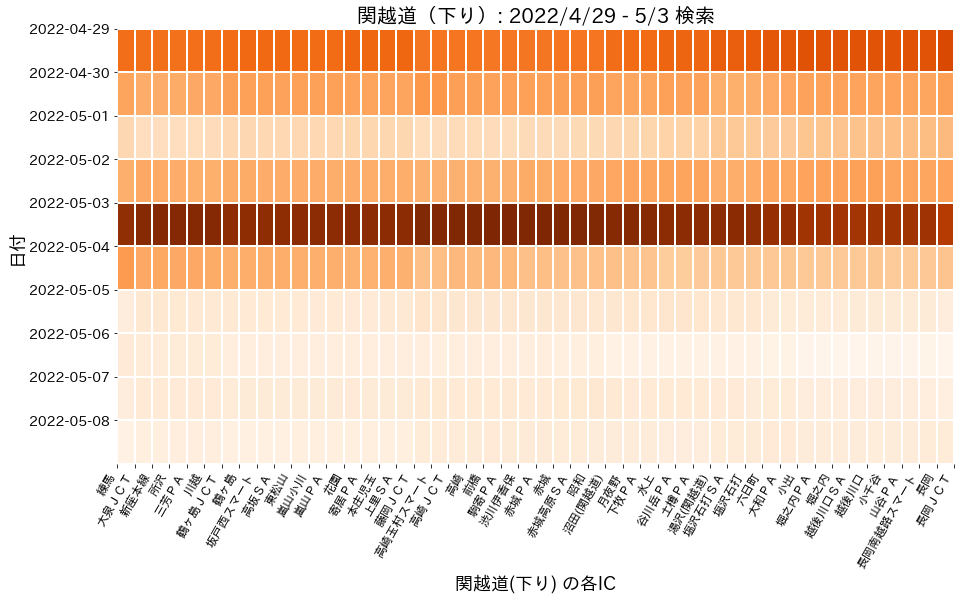

In [91]:
kan_down, kan_up, ts = get_congmat(kan_1d, '1d', '20220429', '20220508', road_code='1800')

values = zscore(kan_down, axis=0)

xlabel = '関越道(下り) の各IC'
ylabel = '日付'
title = '関越道（下り）: 2022/4/29 - 5/3 検索'

xticklabels = [code2name[c] for c in order_kannetsu['down'].keys()]
yticklabels = ts

fig, ax = plt.subplots(1,1, figsize=(15,8))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

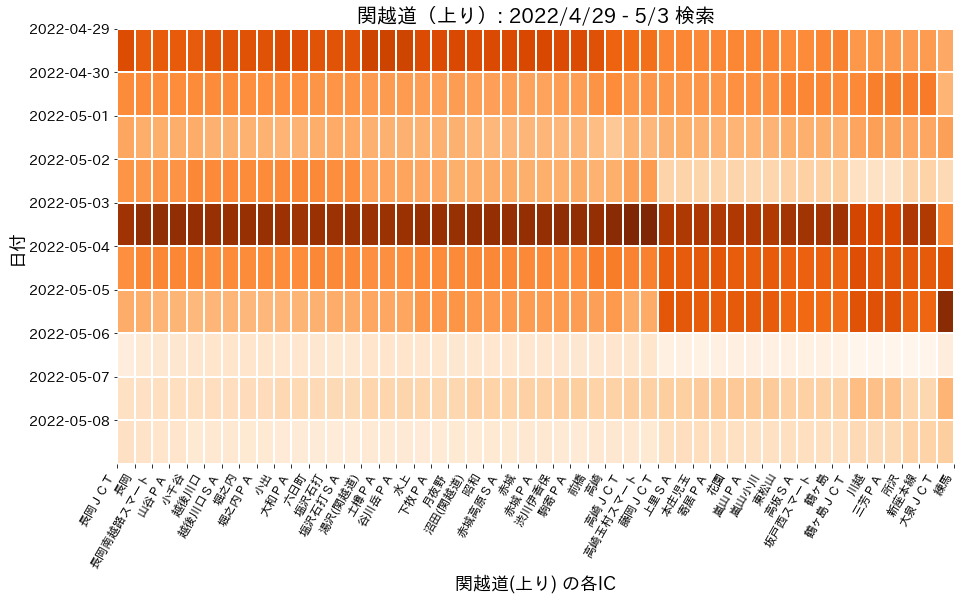

In [92]:
values = zscore(kan_up, axis=0)

xlabel = '関越道(上り) の各IC'
ylabel = '日付'
title = '関越道（上り）: 2022/4/29 - 5/3 検索'

xticklabels = [code2name[c] for c in order_kannetsu['up'].keys()]
yticklabels = ts

fig, ax = plt.subplots(1,1, figsize=(15,8))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

#### 2022/5/3

In [67]:
def get_oneday(df, year, month, day):
    return df[df['datetime'].dt.date == dt.date(year, month, day)]

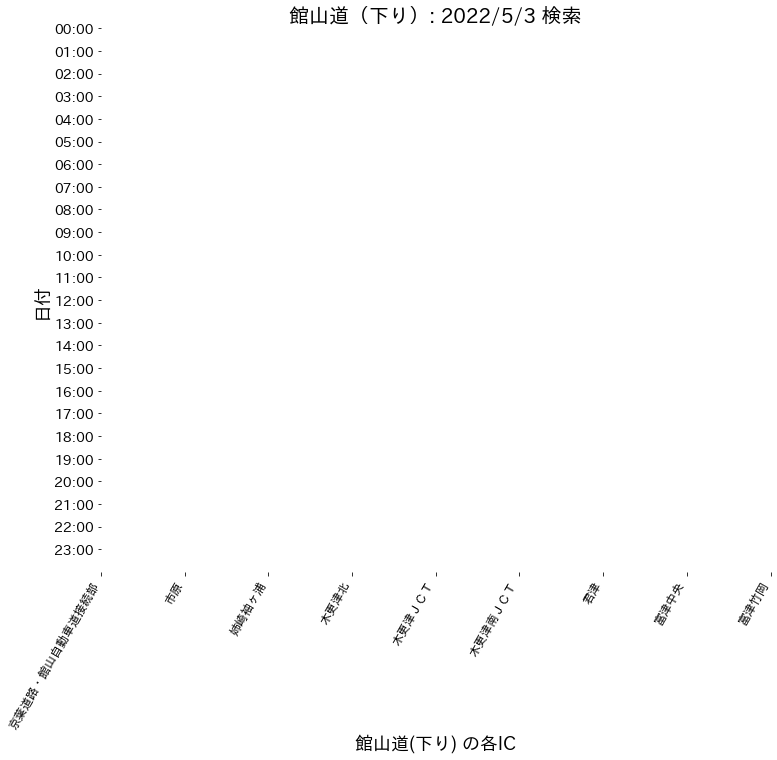

In [84]:
tat_down, tat_up, ts = get_congmat(get_oneday(tat, 2022, 5, 3), '5min', '20220503', road_code='1130', num_col='search_5min')

values = zscore(tat_down, axis=0)

#### plot ####

## decl label, title##
xlabel = '館山道(下り) の各IC'
ylabel = '日付'
title = '館山道（下り）: 2022/5/3 検索'

xticklabels = [code2name[c] for c in order_tateyama['down'].keys()]
yticklabels = [ts[i].split(' ')[1] for i in range(0, len(ts), 12)]

fig, ax = plt.subplots(1,1, figsize=(12,10))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

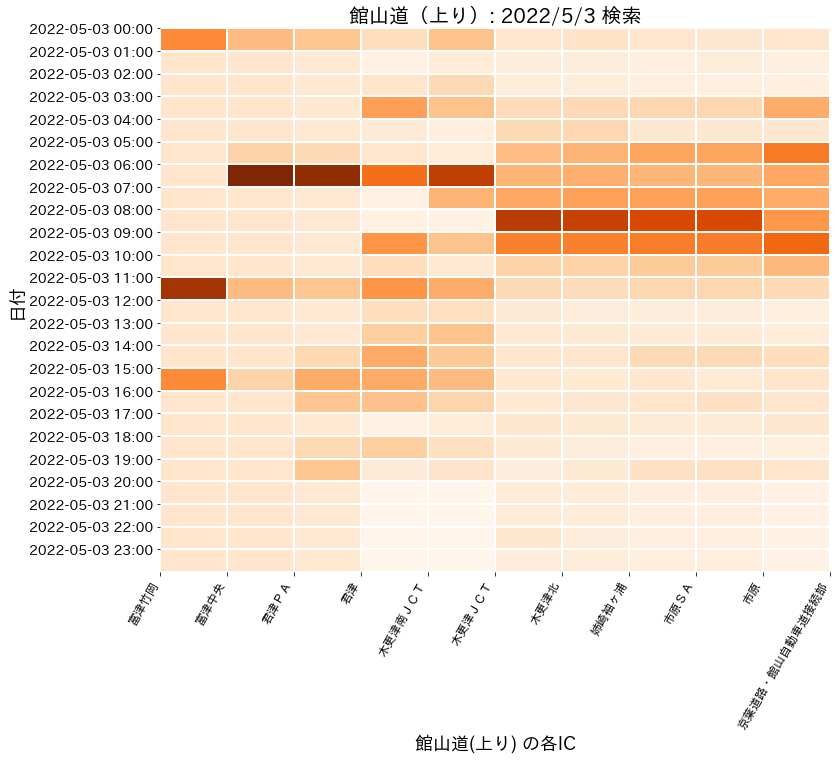

In [96]:
values = zscore(tat_up, axis=0)

#### plot ####

## decl label, title##
xlabel = '館山道(上り) の各IC'
ylabel = '日付'
title = '館山道（上り）: 2022/5/3 検索'

xticklabels = [code2name[c] for c in order_tateyama['up'].keys()]
yticklabels = ts

fig, ax = plt.subplots(1,1, figsize=(12,10))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

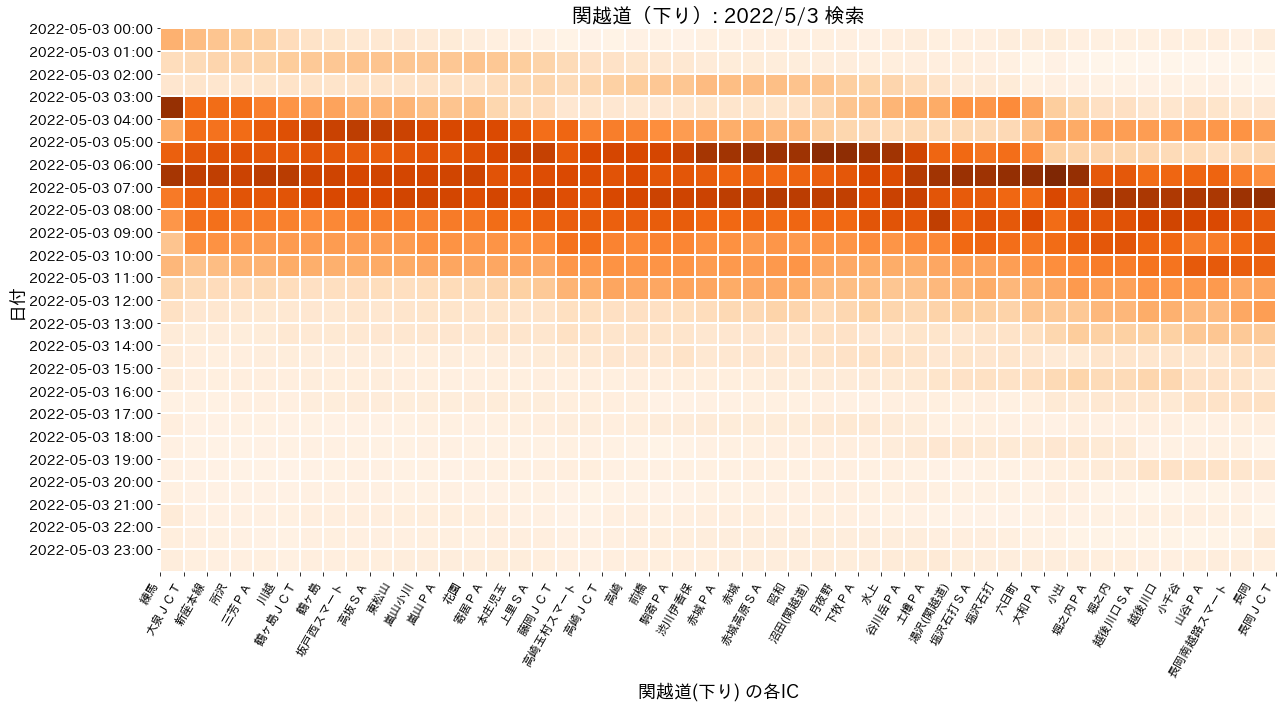

In [97]:
kan_down, kan_up, ts = get_congmat(kan_1h, '1h', '20220503', road_code='1800')

values = zscore(kan_down, axis=0)

#### plot ####

## decl label, title##
xlabel = '関越道(下り) の各IC'
ylabel = '日付'
title = '関越道（下り）: 2022/5/3 検索'

xticklabels = [code2name[c] for c in order_kannetsu['down'].keys()]
yticklabels = ts

fig, ax = plt.subplots(1,1, figsize=(20,10))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

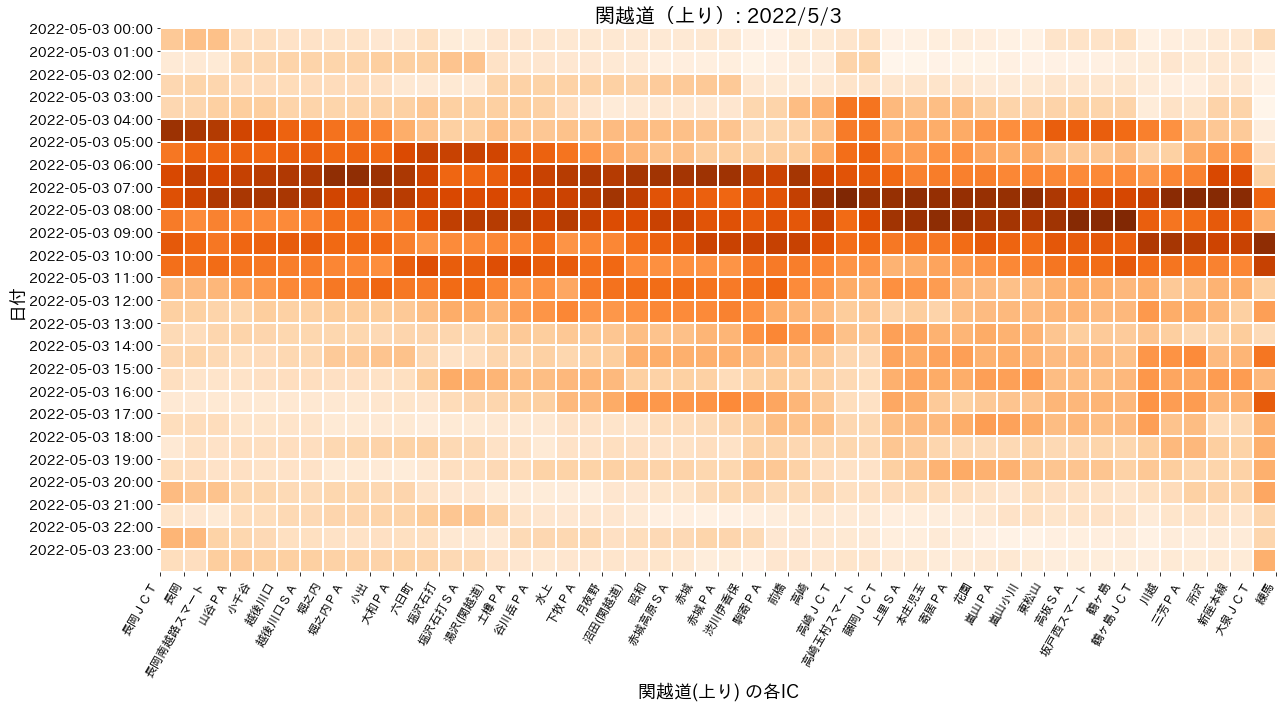

In [98]:
values = zscore(kan_up, axis=0)

#### plot ####

## decl label, title##
xlabel = '関越道(上り) の各IC'
ylabel = '日付'
title = '関越道（上り）: 2022/5/3'

xticklabels = [code2name[c] for c in order_kannetsu['up'].keys()]
yticklabels = ts

fig, ax = plt.subplots(1,1, figsize=(20,10))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

### 「台数」との比較

In [138]:
sr_list = ['1h', '3h', '6h', '1d', '1w', '1m']
for sr in sr_list:
  print('館山道 ({:s}):\t{:.3f}'.format(sr, calc_corr(resample(tat, sr), 'total', 'search')))

print('-'*20)

for sr in sr_list:
  print('関越道 ({:s}):\t{:.3f}'.format(sr, calc_corr(resample(kan, sr), 'total', 'search')))

館山道 (1h):	0.327
館山道 (3h):	0.370
館山道 (6h):	0.397
館山道 (1d):	0.367
館山道 (1w):	0.402
館山道 (1m):	0.403
--------------------
関越道 (1h):	0.339
関越道 (3h):	0.347
関越道 (6h):	0.363
関越道 (1d):	0.403
関越道 (1w):	0.469
関越道 (1m):	0.473


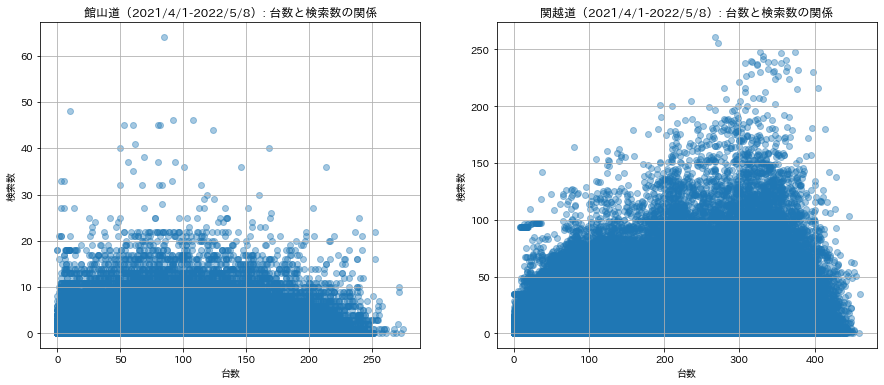

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].scatter(tat['allCars'], tat['search_5min'], alpha=0.4)
axes[0].set_xlabel('台数')
axes[0].set_ylabel('検索数')
axes[0].set_title('館山道（2021/4/1-2022/5/8）: 台数と検索数の関係')
axes[0].grid()

axes[1].scatter(kan['allCars'], kan['search_5min'], alpha=0.4)
axes[1].set_xlabel('台数')
axes[1].set_ylabel('検索数')
axes[1].set_title('関越道（2021/4/1-2022/5/8）: 台数と検索数の関係')
axes[1].grid()

plt.show()

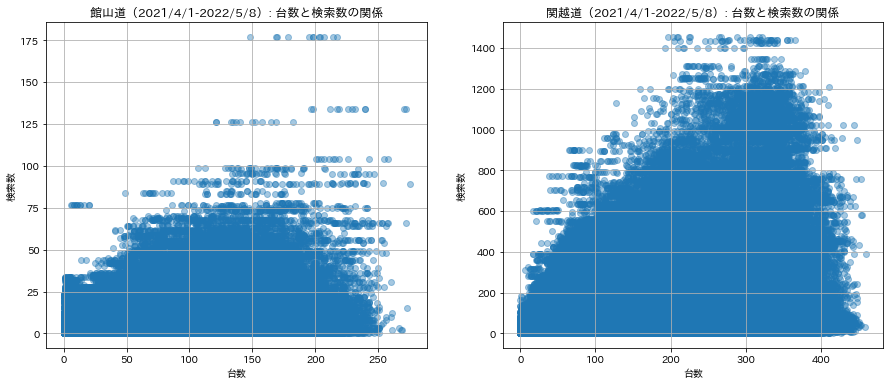

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].scatter(tat['allCars'], tat['search_1h'], alpha=0.4)
axes[0].set_xlabel('台数')
axes[0].set_ylabel('検索数')
axes[0].set_title('館山道（2021/4/1-2022/5/8）: 台数と検索数の関係')
axes[0].grid()

axes[1].scatter(kan['allCars'], kan['search_1h'], alpha=0.4)
axes[1].set_xlabel('台数')
axes[1].set_ylabel('検索数')
axes[1].set_title('関越道（2021/4/1-2022/5/8）: 台数と検索数の関係')
axes[1].grid()

plt.show()

In [39]:
tat_sub = tat[(tat['start_name'] == '木更津ＪＣＴ') & (tat['end_name'] == '木更津南ＪＣＴ')]
kan_sub = kan[(kan['start_name'] == '東松山') & (kan['end_name'] == '嵐山小川')]

In [41]:
tat_sub1 = tat_sub[tat_sub['datetime'].dt.date == dt.date(2022, 5, 3)]
kan_sub1 = kan_sub[kan_sub['datetime'].dt.date == dt.date(2022, 5, 3)]

tat_sub2 = tat_sub[tat_sub['datetime'].dt.date == dt.date(2022, 4, 26)]
kan_sub2 = kan_sub[kan_sub['datetime'].dt.date == dt.date(2022, 4, 26)]

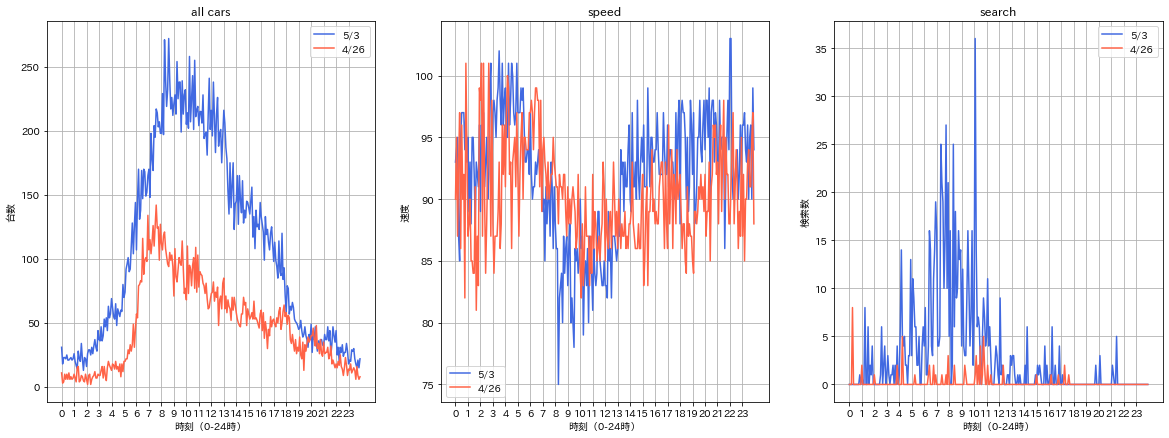

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
ticks = range(0, 288, 12)
labels = range(24)

ax = axes[0]
ax.plot(range(288), tat_sub1['allCars'], color='royalblue', label='5/3')
ax.plot(range(288), tat_sub2['allCars'], color='tomato', label='4/26')
ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('台数')
ax.set_title('all cars')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()
ax.legend()

ax = axes[1]
ax.plot(range(288), tat_sub1['speed'], color='royalblue', label='5/3')
ax.plot(range(288), tat_sub2['speed'], color='tomato', label='4/26')

ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('速度')
ax.set_title('speed')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()
ax.legend()

ax = axes[2]
ax.plot(range(288), tat_sub1['search_5min'], color='royalblue', label='5/3')
ax.plot(range(288), tat_sub2['search_5min'], color='tomato', label='4/26')

ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('検索数')
ax.set_title('search')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()
ax.legend()

plt.show()

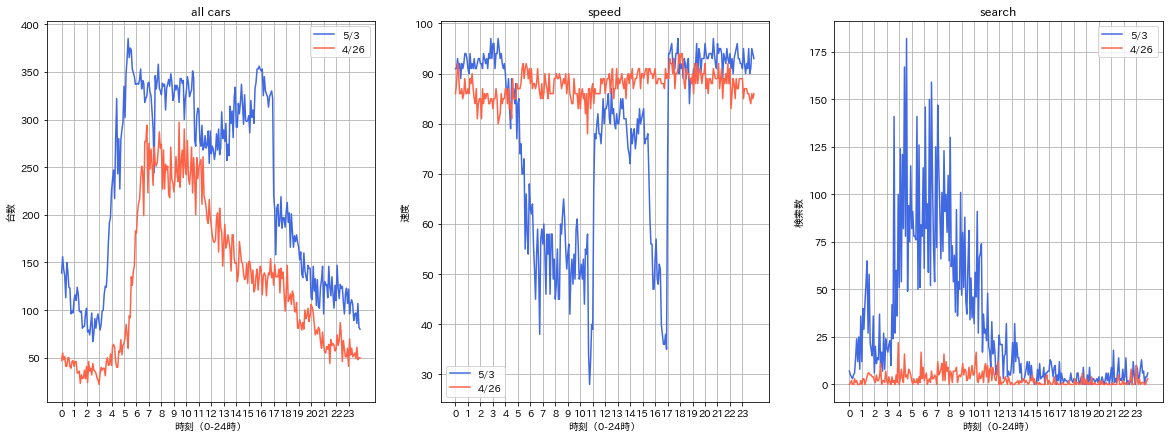

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(20,7))
ticks = range(0, 288, 12)
labels = range(24)

ax = axes[0]
ax.plot(range(288), kan_sub1['allCars'], color='royalblue', label='5/3')
ax.plot(range(288), kan_sub2['allCars'], color='tomato', label='4/26')
ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('台数')
ax.set_title('all cars')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()
ax.legend()

ax = axes[1]
ax.plot(range(288), kan_sub1['speed'], color='royalblue', label='5/3')
ax.plot(range(288), kan_sub2['speed'], color='tomato', label='4/26')

ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('速度')
ax.set_title('speed')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()
ax.legend()

ax = axes[2]
ax.plot(range(288), kan_sub1['search_5min'], color='royalblue', label='5/3')
ax.plot(range(288), kan_sub2['search_5min'], color='tomato', label='4/26')

ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('検索数')
ax.set_title('search')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()
ax.legend()

plt.show()

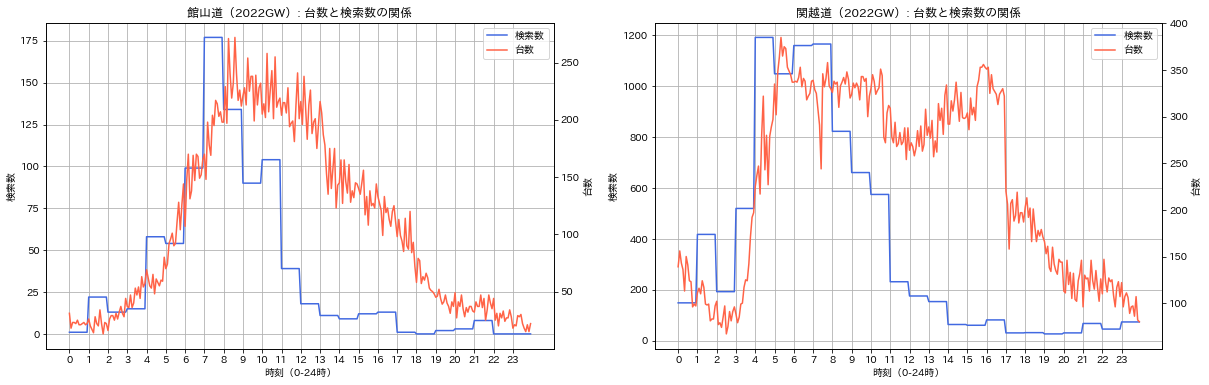

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
ticks = range(0, 288, 12)
labels = range(24)

ax = axes[0]
ax2 = ax.twinx()
ax.plot(range(288), tat_sub1['search_1h'], color='royalblue', label='検索数')
ax2.plot(range(288), tat_sub1['allCars'], color='tomato', label='台数')
ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('館山道（2022GW）: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

ax = axes[1]
ax2 = ax.twinx()
ax.plot(range(288), kan_sub1['search_1h'], color='royalblue', label='検索数')
ax2.plot(range(288), kan_sub1['allCars'], color='tomato', label='台数')

ax.set_xlabel('時刻（0-24時）')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('関越道（2022GW）: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

plt.show()

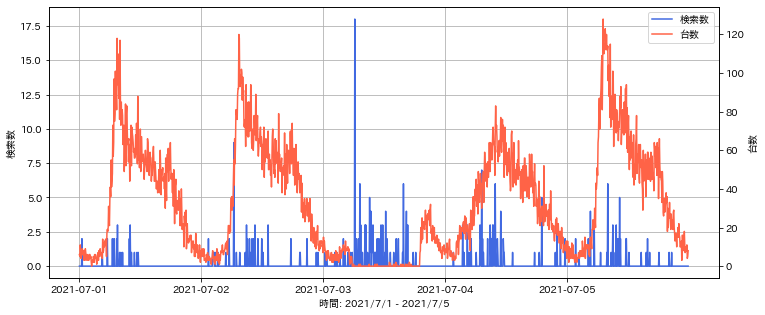

In [66]:
tmp = tat[(tat['datetime'] >= pd.Timestamp('2021/7/1')) & (tat['datetime'] < pd.Timestamp('2021/7/6'))]
tmp = tmp[(tmp['start_name'] == '木更津ＪＣＴ') & (tmp['end_name'] == '木更津南ＪＣＴ')]

xs = range(12 * 24 * 5)
ticks = range(0, len(xs), 12*24)
labels = tmp['datetime'].dt.date.unique()

fig, ax = plt.subplots(figsize=(12, 5))
ax2 = ax.twinx()
ax.plot(xs, tmp['search_5min'], color='royalblue', label='検索数')
ax2.plot(xs, tmp['allCars'], color='tomato', label='台数')
ax.set_xlabel('時間: 2021/7/1 - 2021/7/5')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

plt.show()

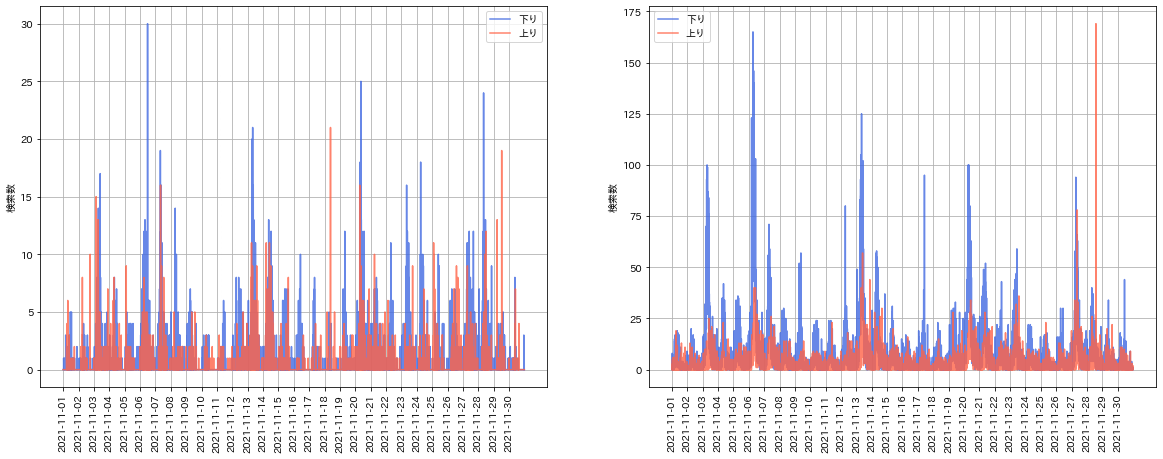

In [113]:
tat_sub = tat[tat['datetime'].dt.month == 11]
kan_sub = kan[kan['datetime'].dt.month == 11]
tat_sub1 = tat_sub[(tat_sub['start_name'] == '木更津ＪＣＴ') & (tat_sub['end_name'] == '木更津南ＪＣＴ')]
tat_sub2 = tat_sub[(tat_sub['end_name'] == '木更津ＪＣＴ') & (tat_sub['start_name'] == '木更津南ＪＣＴ')]
kan_sub1 = kan_sub[(kan_sub['start_name'] == '東松山') & (kan_sub['end_name'] == '嵐山小川')]
kan_sub2 = kan_sub[(kan_sub['end_name'] == '東松山') & (kan_sub['start_name'] == '嵐山小川')]


fig, axes = plt.subplots(1, 2, figsize=(20, 7))
xs = range(12 * 24 * 30)
ticks = range(0, 12 * 24 * 30, 12 * 24)
labels = tat_sub['datetime'].dt.date.unique()

ax = axes[0]
ax.plot(xs, tat_sub1['search_5min'], color='royalblue', label='下り', alpha=0.8)
ax.plot(xs, tat_sub2['search_5min'], color='tomato', label='上り', alpha=0.8)
ax.set_ylabel('検索数')
ax.set_xticks(ticks=ticks, labels=labels, rotation=90)
ax.grid()

ax.legend()

ax = axes[1]
ax.plot(xs, kan_sub1['search_5min'], color='royalblue', label='下り', alpha=0.8)
ax.plot(xs, kan_sub2['search_5min'], color='tomato', label='上り', alpha=0.8)
ax.set_ylabel('検索数')
ax.set_xticks(ticks=ticks, labels=labels, rotation=90)
ax.grid()

ax.legend()

plt.show()

## 時間指定なしデータ

### 可視化

In [6]:
def resample_search(df, sr):
  agg_map = {
      'search': 'sum'
  }

  return df.set_index('search_date').groupby(['start_code', 'end_code']).apply(lambda g: g.resample(sr).agg(agg_map)).reset_index()

def resample_traffic(df, sr):
  agg_map = {
    'total': 'sum',
    'speed': 'mean',
    'KP': 'mean'
  }

  return df.set_index('datetime').groupby(['start_name', 'end_name']).apply(lambda g: g.resample(sr).agg(agg_map)).reset_index()

In [91]:
df_tateyama = pd.read_csv(UNSPECIFIED_SEARCH_COUNT_TATEYAMA_CSV, index_col='search_date', parse_dates=True,
                          dtype={'start_code': str, 'end_code': str}).reset_index()
df_kannetsu = pd.read_csv(UNSPECIFIED_SEARCH_COUNT_KANNETSU_CSV, index_col='search_date', parse_dates=True,
                          dtype={'start_code': str, 'end_code': str}).reset_index()

# df_tateyama['search'] = df_tateyama.groupby(['start_code','end_code'])['search'].shift(1)
# df_kannetsu['search'] = df_kannetsu.groupby(['start_code','end_code'])['search'].shift(1)

In [67]:
df_tateyama.describe()

,search
count,8057.000000
mean,361.169666
std,239.094603
min,1.000000
25%,166.000000
50%,364.000000
75%,512.000000
max,3643.000000


In [68]:
df_kannetsu.describe()

,search
count,38688.000000
mean,2210.219655
std,1741.351511
min,184.000000
25%,909.000000
50%,1613.000000
75%,2938.000000
max,12794.000000


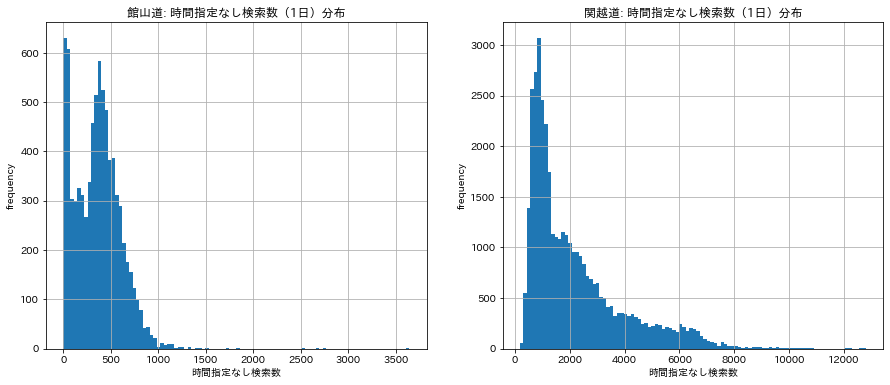

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(df_tateyama['search'], bins=100)
axes[0].set_xlabel('時間指定なし検索数')
axes[0].set_ylabel('frequency')
axes[0].set_title('館山道: 時間指定なし検索数（1日）分布')
axes[0].grid()

axes[1].hist(df_kannetsu['search'], bins=100)
axes[1].set_xlabel('時間指定なし検索数')
axes[1].set_ylabel('frequency')
axes[1].set_title('関越道: 時間指定なし検索数（1日）分布')
axes[1].grid()

plt.show()

In [72]:
df_tateyama.sort_values('search', ascending=False)

,search_date,start_code,end_code,search,start_name,end_name
4828,2021-11-28,1130031,1130026,3643,木更津南ＪＣＴ,木更津ＪＣＴ
4830,2021-11-28,1130036,1130031,2761,君津,木更津南ＪＣＴ
4832,2021-11-28,1130039,1130036,2670,君津ＰＡ,君津
4834,2021-11-28,1130041,1130039,2525,富津中央,君津ＰＡ
7927,2022-05-02,1130026,1130031,1847,木更津ＪＣＴ,木更津南ＪＣＴ
...,...,...,...,...,...,...
1337,2021-06-06,1130046,1130041,1,富津竹岡,富津中央
2676,2021-08-12,1130046,1130041,1,富津竹岡,富津中央
1916,2021-07-05,1130046,1130041,1,富津竹岡,富津中央
3956,2021-10-15,1130046,1130041,1,富津竹岡,富津中央


In [73]:
df_kannetsu.sort_values('search', ascending=False)

,search_date,start_code,end_code,search,start_name,end_name
38029,2022-05-02,1800021,1800026,12794,鶴ヶ島ＪＣＴ,鶴ヶ島
38031,2022-05-02,1800026,1800028,12774,鶴ヶ島,坂戸西スマート
38037,2022-05-02,1800036,1800041,12750,東松山,嵐山小川
38033,2022-05-02,1800028,1800031,12711,坂戸西スマート,高坂ＳＡ
38035,2022-05-02,1800031,1800036,12711,高坂ＳＡ,東松山
...,...,...,...,...,...,...
4513,2021-05-18,1110210,1800001,216,大泉ＪＣＴ,練馬
3457,2021-05-07,1110210,1800001,206,大泉ＪＣＴ,練馬
5377,2021-05-27,1110210,1800001,204,大泉ＪＣＴ,練馬
3937,2021-05-12,1110210,1800001,197,大泉ＪＣＴ,練馬


In [74]:
df_tateyama.groupby(['start_name', 'end_name']).mean().reset_index().sort_values('search', ascending=False)

,start_name,end_name,search
19,木更津ＪＣＴ,木更津南ＪＣＴ,758.300248
0,京葉道路・館山自動車道接続部,市原,675.803970
11,市原,市原ＳＡ,561.565757
12,市原ＳＡ,姉崎袖ヶ浦,561.565757
16,木更津南ＪＣＴ,君津,558.347395
6,姉崎袖ヶ浦,木更津北,498.022333
15,木更津北,木更津ＪＣＴ,491.791563
18,木更津ＪＣＴ,木更津北,418.101737
10,市原,京葉道路・館山自動車道接続部,412.965261
14,木更津北,姉崎袖ヶ浦,356.359801


In [75]:
df_kannetsu.groupby(['start_name', 'end_name']).mean().reset_index().sort_values('search', ascending=False)

,start_name,end_name,search
95,鶴ヶ島ＪＣＴ,鶴ヶ島,6032.389578
92,鶴ヶ島,坂戸西スマート,5988.573201
12,坂戸西スマート,高坂ＳＡ,5932.483871
85,高坂ＳＡ,東松山,5932.483871
50,東松山,嵐山小川,5872.466501
...,...,...,...
17,堀之内ＰＡ,小出,766.325062
14,堀之内,堀之内ＰＡ,766.325062
6,六日町,塩沢石打,759.181141
22,大和ＰＡ,六日町,758.071960


In [76]:
tmp_tat = df_tateyama.groupby(['search_date']).apply(lambda g: g['search'].agg(sum='sum')).reset_index()
tmp_kan = df_kannetsu.groupby(['search_date']).apply(lambda g: g['search'].agg(sum='sum')).reset_index()

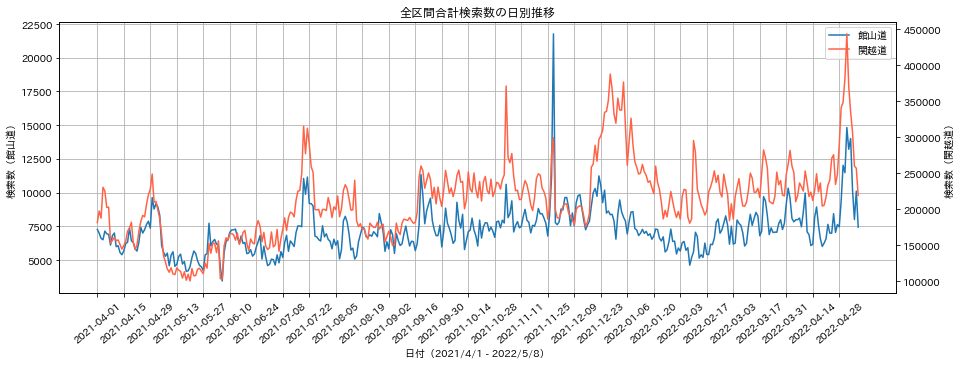

In [77]:
fig, ax = plt.subplots(figsize=(15,5))
ax2 = ax.twinx()

ax.plot(range(len(tmp_tat)), tmp_tat['sum'], label='館山道', lw=1.5)
ax2.plot(range(len(tmp_kan)), tmp_kan['sum'], color='tomato', label='関越道', lw=1.5)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

ax.set_xlabel('日付（2021/4/1 - 2022/5/8）')
ax.set_ylabel('検索数（館山道）')
ax2.set_ylabel('検索数（関越道）')
ax.set_title('全区間合計検索数の日別推移')

ticks = range(0, len(tmp_tat), 14)
ax.set_xticks(ticks=ticks, labels=tmp_tat['search_date'].iloc[ticks].dt.date, rotation=40)

ax.grid()

plt.show()

In [93]:
df_tateyama['start_name'] = df_tateyama['start_code'].map(code2name)
df_tateyama['end_name'] = df_tateyama['end_code'].map(code2name)
df_kannetsu['start_name'] = df_kannetsu['start_code'].map(code2name)
df_kannetsu['end_name'] = df_kannetsu['end_code'].map(code2name)

In [78]:
df_tateyama.sort_values('search', ascending=False)[['start_name', 'end_name', 'search', 'search_date']].head(15).reset_index(drop=True)

,start_name,end_name,search,search_date
0,木更津南ＪＣＴ,木更津ＪＣＴ,3643,2021-11-28
1,君津,木更津南ＪＣＴ,2761,2021-11-28
2,君津ＰＡ,君津,2670,2021-11-28
3,富津中央,君津ＰＡ,2525,2021-11-28
4,木更津ＪＣＴ,木更津南ＪＣＴ,1847,2022-05-02
5,木更津ＪＣＴ,木更津南ＪＣＴ,1737,2022-05-03
6,木更津ＪＣＴ,木更津南ＪＣＴ,1509,2022-05-04
7,木更津ＪＣＴ,木更津南ＪＣＴ,1442,2022-05-01
8,木更津ＪＣＴ,木更津南ＪＣＴ,1409,2021-09-19
9,木更津ＪＣＴ,木更津南ＪＣＴ,1348,2022-04-30


In [79]:
df_kannetsu.sort_values('search', ascending=False)[['start_name', 'end_name', 'search', 'search_date']].head(15).reset_index(drop=True)

,start_name,end_name,search,search_date
0,鶴ヶ島ＪＣＴ,鶴ヶ島,12794,2022-05-02
1,鶴ヶ島,坂戸西スマート,12774,2022-05-02
2,東松山,嵐山小川,12750,2022-05-02
3,坂戸西スマート,高坂ＳＡ,12711,2022-05-02
4,高坂ＳＡ,東松山,12711,2022-05-02
5,嵐山小川,嵐山ＰＡ,12614,2022-05-02
6,嵐山ＰＡ,花園,12614,2022-05-02
7,上里ＳＡ,藤岡ＪＣＴ,12183,2022-05-02
8,本庄児玉,上里ＳＡ,12165,2022-05-02
9,花園,寄居ＰＡ,12124,2022-05-02


### ヒートマップ

#### 2022/4/29 - 2022/5/8

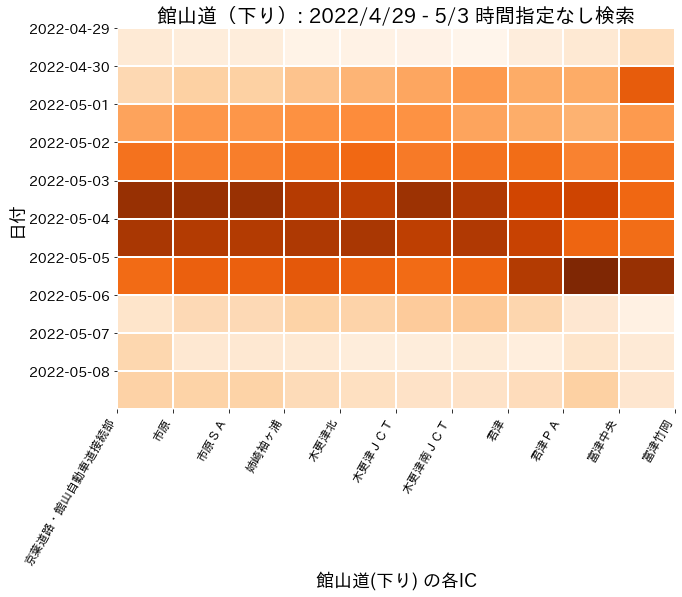

In [22]:
tat_down, tat_up, ts = get_congmat(df_tateyama, '1d', '20220429', '20220508', road_code='1130', df_type='search_unspecified')

values = zscore(tat_down, axis=0)

xlabel = '館山道(下り) の各IC'
ylabel = '日付'
title = '館山道（下り）: 2022/4/29 - 5/3 時間指定なし検索'

xticklabels = [code2name[c] for c in order_tateyama['down'].keys()]
yticklabels = ts

fig, ax = plt.subplots(1,1, figsize=(10,7))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

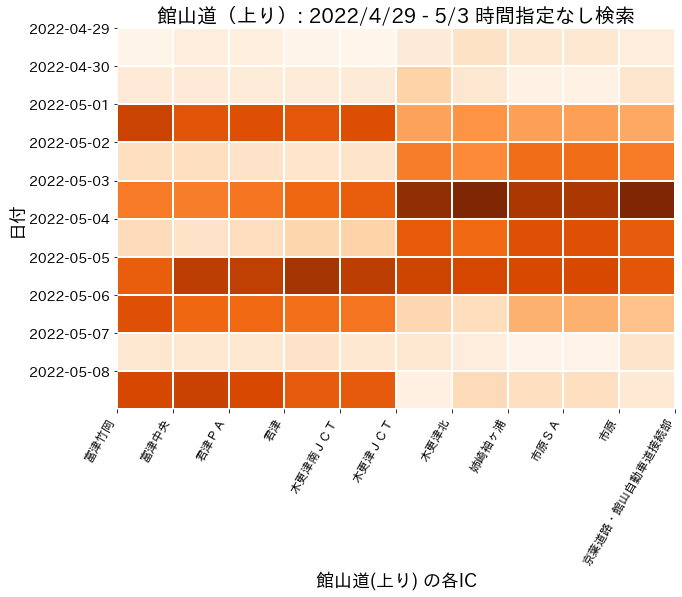

In [23]:
values = zscore(tat_up, axis=0)

xlabel = '館山道(上り) の各IC'
ylabel = '日付'
title = '館山道（上り）: 2022/4/29 - 5/3 時間指定なし検索'

xticklabels = [code2name[c] for c in order_tateyama['up'].keys()]
yticklabels = ts

fig, ax = plt.subplots(1,1, figsize=(10,7))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

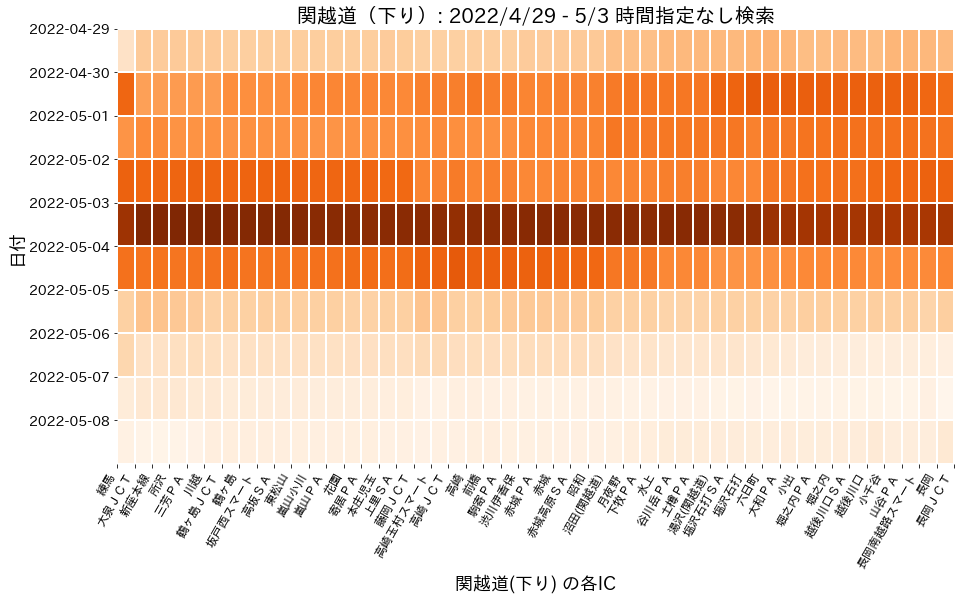

In [24]:
kan_down, kan_up, ts = get_congmat(df_kannetsu, '1d', '20220429', '20220508', road_code='1800', df_type='search_unspecified')

values = zscore(kan_down, axis=0)

xlabel = '関越道(下り) の各IC'
ylabel = '日付'
title = '関越道（下り）: 2022/4/29 - 5/3 時間指定なし検索'

xticklabels = [code2name[c] for c in order_kannetsu['down'].keys()]
yticklabels = ts

fig, ax = plt.subplots(1,1, figsize=(15,8))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

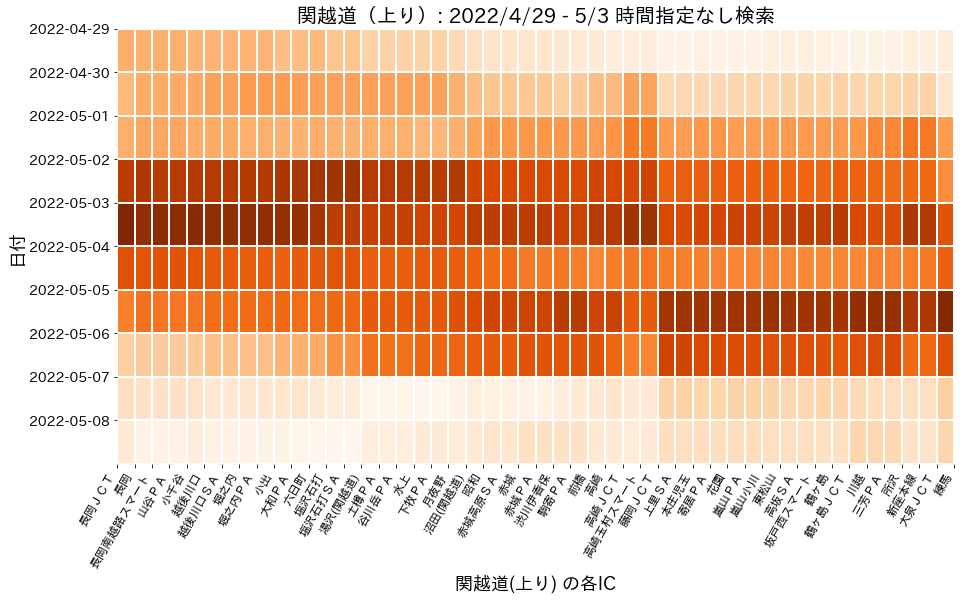

In [25]:
values = zscore(kan_up, axis=0)

xlabel = '関越道(上り) の各IC'
ylabel = '日付'
title = '関越道（上り）: 2022/4/29 - 5/3 時間指定なし検索'

xticklabels = [code2name[c] for c in order_kannetsu['up'].keys()]
yticklabels = ts

fig, ax = plt.subplots(1,1, figsize=(15,8))

plot_heatmap(values, xlabel, ylabel, title, xticklabels, yticklabels, ax)

### 「台数」との比較

In [26]:
def merge_traffic_search(traffic, search):
  df = pd.merge(traffic, search, how='left',
                left_on=['datetime', 'start_name', 'end_name'], 
                right_on=['search_date', 'start_name', 'end_name'])
  df.drop('search_date', axis=1, inplace=True)
  df['search'].fillna(0, inplace=True)

  df['start_code'] = df['start_name'].map(name2code)
  df['end_code'] = df['end_name'].map(name2code)

  cols = ['datetime', 'start_code', 'end_code', 'start_name', 'end_name', 'KP', 'total', 'speed', 'search']
  return df.loc[:,cols]

In [27]:
df_tateyama_traffic = pd.read_csv(TRAFFIC_TATEYAMA_CSV, index_col='datetime', parse_dates=True, 
                                  dtype={'start_code': str, 'end_code': str}).reset_index()

df_kannetsu_traffic = pd.read_csv(TRAFFIC_KANNETSU_CSV, index_col='datetime', parse_dates=True, 
                                  dtype={'start_code': str, 'end_code': str}).reset_index()

In [28]:
tat_tra1d = resample_traffic(df_tateyama_traffic, '1d')
kan_tra1d = resample_traffic(df_kannetsu_traffic, '1d')

In [29]:
tat_tra1d.sort_values('total', ascending=False)[['start_name', 'end_name', 'total', 'datetime']].head(15).reset_index(drop=True)

,start_name,end_name,total,datetime
0,木更津ＪＣＴ,木更津南ＪＣＴ,31213.0,2022-05-03
1,京葉道路・館山自動車道接続部,市原,31122.0,2022-05-03
2,市原,姉崎袖ヶ浦,28915.0,2022-05-03
3,木更津ＪＣＴ,木更津南ＪＣＴ,28247.0,2022-05-04
4,京葉道路・館山自動車道接続部,市原,27985.0,2022-05-04
5,京葉道路・館山自動車道接続部,市原,27835.0,2021-12-24
6,京葉道路・館山自動車道接続部,市原,27402.0,2021-07-21
7,京葉道路・館山自動車道接続部,市原,27342.0,2021-08-10
8,京葉道路・館山自動車道接続部,市原,27109.0,2022-03-20
9,京葉道路・館山自動車道接続部,市原,27084.0,2021-05-03


In [30]:
kan_tra1d.sort_values('total', ascending=False)[['start_name', 'end_name', 'total', 'datetime']].head(15).reset_index(drop=True)

,start_name,end_name,total,datetime
0,鶴ヶ島,鶴ヶ島ＪＣＴ,70228.0,2022-05-05
1,鶴ヶ島ＪＣＴ,鶴ヶ島,69333.0,2022-05-02
2,坂戸西スマート,鶴ヶ島,67697.0,2022-05-05
3,嵐山小川,花園,66620.0,2022-05-03
4,鶴ヶ島,坂戸西スマート,66494.0,2022-05-02
5,鶴ヶ島,鶴ヶ島ＪＣＴ,66373.0,2022-05-04
6,鶴ヶ島ＪＣＴ,鶴ヶ島,66272.0,2022-03-19
7,東松山,嵐山小川,65957.0,2022-05-03
8,鶴ヶ島ＪＣＴ,鶴ヶ島,65272.0,2022-04-28
9,東松山,坂戸西スマート,65214.0,2022-05-05


#### 台数との相関

In [87]:
# df_tateyama['search'] = df_tateyama.groupby(['start_code','end_code'])['search'].shift(1)
# df_kannetsu['search'] = df_kannetsu.groupby(['start_code','end_code'])['search'].shift(1)

In [94]:
tat = merge_traffic_search(tat_tra1d, df_tateyama)
kan = merge_traffic_search(kan_tra1d, df_kannetsu)

In [95]:
def calc_corr(df, col1, col2):
  return df[[col1, col2]].corr().values[0, 1]

館山道: 0.440
関越道: 0.550


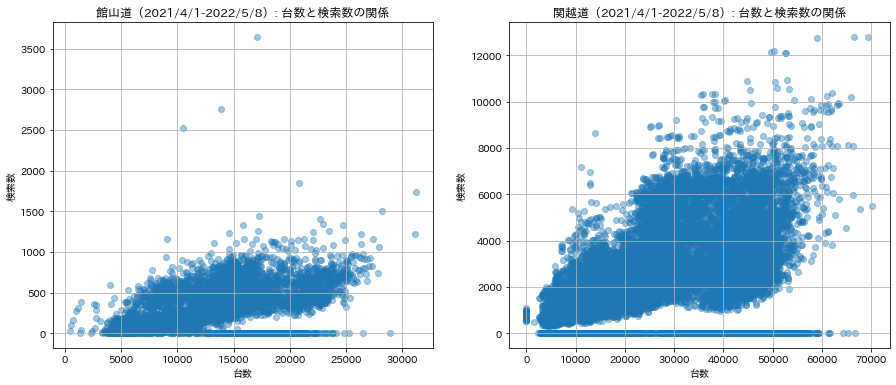

In [96]:
print('館山道: {:.3f}'.format(calc_corr(tat, 'total', 'search')))
print('関越道: {:.3f}'.format(calc_corr(kan, 'total', 'search')))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].scatter(tat['total'], tat['search'], alpha=0.4)
axes[0].set_xlabel('台数')
axes[0].set_ylabel('検索数')
axes[0].set_title('館山道（2021/4/1-2022/5/8）: 台数と検索数の関係')
axes[0].grid()

axes[1].scatter(kan['total'], kan['search'], alpha=0.4)
axes[1].set_xlabel('台数')
axes[1].set_ylabel('検索数')
axes[1].set_title('関越道（2021/4/1-2022/5/8）: 台数と検索数の関係')
axes[1].grid()

plt.show()

館山道: 0.644
関越道: 0.586


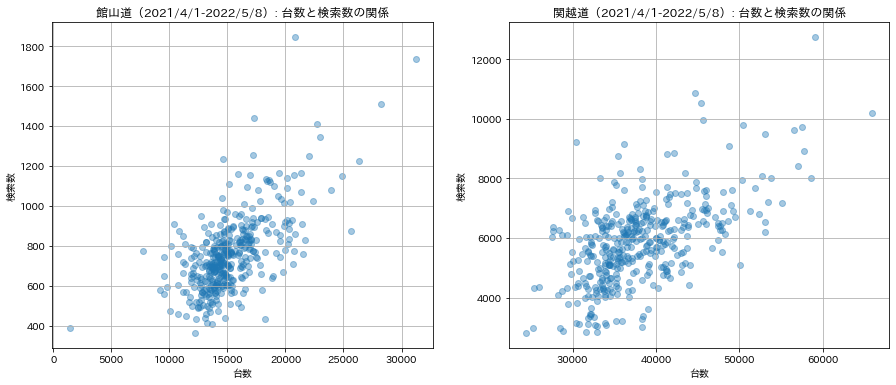

In [98]:
tat_sub = tat[(tat['start_name'] == '木更津ＪＣＴ') & (tat['end_name'] == '木更津南ＪＣＴ')]
kan_sub = kan[(kan['start_name'] == '東松山') & (kan['end_name'] == '嵐山小川')]

print('館山道: {:.3f}'.format(calc_corr(tat_sub, 'total', 'search')))
print('関越道: {:.3f}'.format(calc_corr(kan_sub, 'total', 'search')))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].scatter(tat_sub['total'], tat_sub['search'], alpha=0.4)
axes[0].set_xlabel('台数')
axes[0].set_ylabel('検索数')
axes[0].set_title('館山道（2021/4/1-2022/5/8）: 台数と検索数の関係')
axes[0].grid()

axes[1].scatter(kan_sub['total'], kan_sub['search'], alpha=0.4)
axes[1].set_xlabel('台数')
axes[1].set_ylabel('検索数')
axes[1].set_title('関越道（2021/4/1-2022/5/8）: 台数と検索数の関係')
axes[1].grid()

plt.show()

#### 年間推移

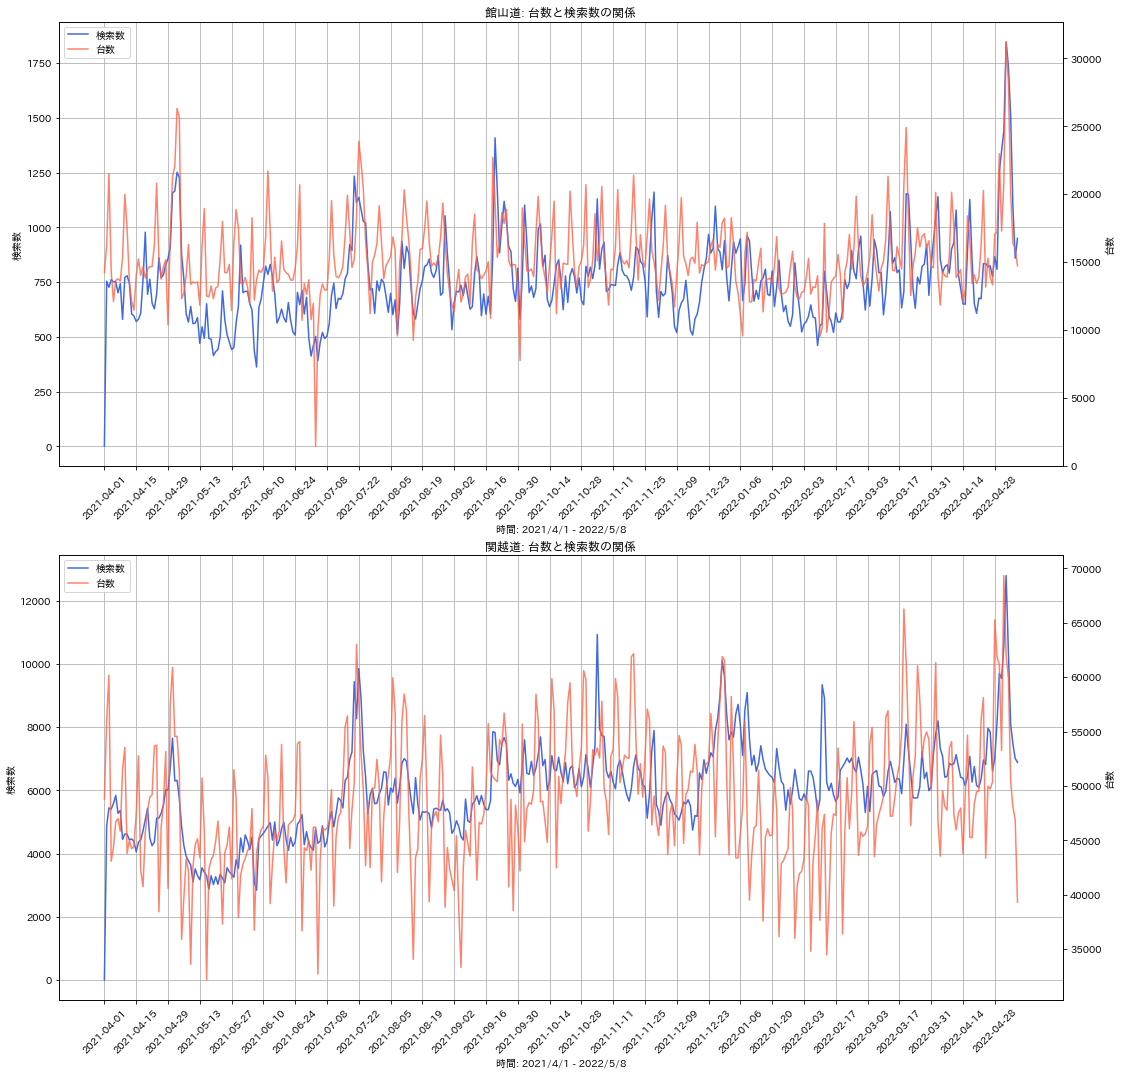

In [81]:
# tat_sub = tat[(tat['datetime'] >= pd.Timestamp('2022/4/29')) & (tat['datetime'] < pd.Timestamp('2022/5/9'))]
# kan_sub = kan[(kan['datetime'] >= pd.Timestamp('2022/4/29')) & (kan['datetime'] < pd.Timestamp('2022/5/9'))]
tat_sub = tat[(tat['start_name'] == '木更津ＪＣＴ') & (tat['end_name'] == '木更津南ＪＣＴ')]
kan_sub = kan[(kan['start_name'] == '鶴ヶ島ＪＣＴ') & (kan['end_name'] == '鶴ヶ島')]


fig, axes = plt.subplots(2, 1, figsize=(18, 18))
xs = range(len(tat_sub))
ticks = range(0, len(tat_sub), 14)
labels = tat_sub['datetime'].dt.date.iloc[ticks]

ax = axes[0]
ax2 = ax.twinx()
ax.plot(xs, tat_sub['search'], color='royalblue', label='検索数')
ax2.plot(xs, tat_sub['total'], color='tomato', label='台数', alpha=0.8)
ax.set_xlabel('時間: 2021/4/1 - 2022/5/8')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('館山道: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels, rotation=45)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

ax = axes[1]
ax2 = ax.twinx()
ax.plot(xs, kan_sub['search'], color='royalblue', label='検索数')
ax2.plot(xs, kan_sub['total'], color='tomato', label='台数', alpha=0.8)

ax.set_xlabel('時間: 2021/4/1 - 2022/5/8')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('関越道: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels, rotation=45)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

plt.show()

#### GW推移

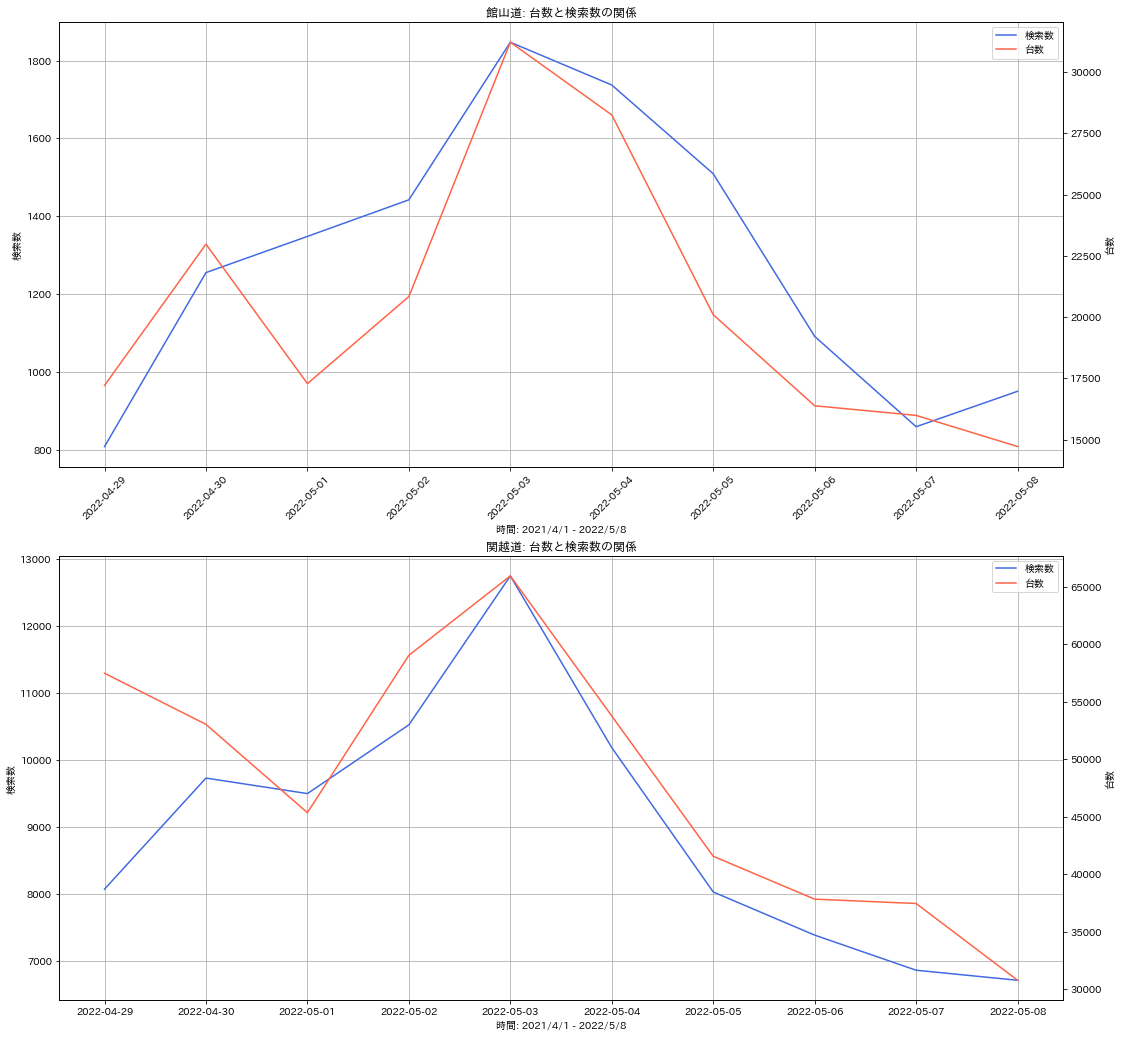

In [44]:
tat_sub = tat[(tat['datetime'] >= pd.Timestamp('2022/4/29')) & (tat['datetime'] < pd.Timestamp('2022/5/9'))]
kan_sub = kan[(kan['datetime'] >= pd.Timestamp('2022/4/29')) & (kan['datetime'] < pd.Timestamp('2022/5/9'))]
tat_sub = tat_sub[(tat_sub['start_name'] == '木更津ＪＣＴ') & (tat_sub['end_name'] == '木更津南ＪＣＴ')]
kan_sub = kan_sub[(kan_sub['start_name'] == '東松山') & (kan_sub['end_name'] == '嵐山小川')]


fig, axes = plt.subplots(2, 1, figsize=(18, 18))
xs = range(len(tat_sub))
ticks = range(len(tat_sub))
labels = tat_sub['datetime'].dt.date.iloc[ticks]

ax = axes[0]
ax2 = ax.twinx()
ax.plot(xs, tat_sub['search'], color='royalblue', label='検索数')
ax2.plot(xs, tat_sub['total'], color='tomato', label='台数')
ax.set_xlabel('時間: 2021/4/1 - 2022/5/8')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('館山道: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels, rotation=45)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

ax = axes[1]
ax2 = ax.twinx()
ax.plot(xs, kan_sub['search'], color='royalblue', label='検索数')
ax2.plot(xs, kan_sub['total'], color='tomato', label='台数')

ax.set_xlabel('時間: 2021/4/1 - 2022/5/8')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('関越道: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

plt.show()

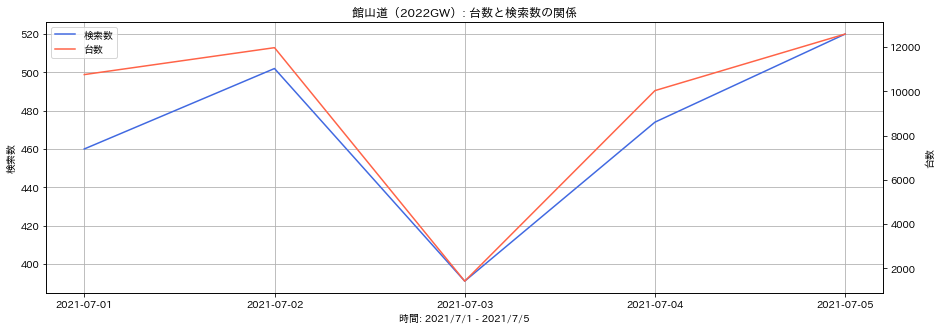

In [99]:
tmp = tat[(tat['datetime'] >= pd.Timestamp('2021/7/1')) & (tat['datetime'] < pd.Timestamp('2021/7/6'))]
tmp = tmp[(tmp['start_name'] == '木更津ＪＣＴ') & (tmp['end_name'] == '木更津南ＪＣＴ')]

xs = range(5)
ticks = range(5)
labels = tmp['datetime'].dt.date.unique()

fig, ax = plt.subplots(figsize=(15, 5))
ax2 = ax.twinx()
ax.plot(xs, tmp['search'], color='royalblue', label='検索数')
ax2.plot(xs, tmp['total'], color='tomato', label='台数')
ax.set_xlabel('時間: 2021/7/1 - 2021/7/5')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('館山道（2022GW）: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

plt.show()

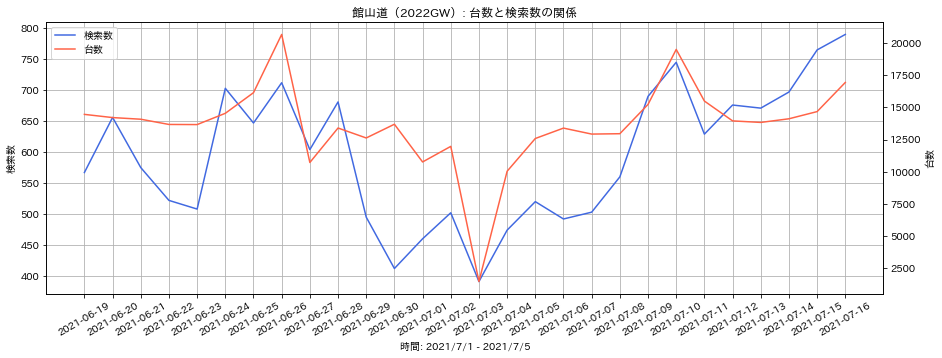

In [104]:
tmp = tat[(tat['datetime'] >= pd.Timestamp('2021/6/19')) & (tat['datetime'] < pd.Timestamp('2021/7/17'))]
tmp = tmp[(tmp['start_name'] == '木更津ＪＣＴ') & (tmp['end_name'] == '木更津南ＪＣＴ')]

xs = range(28)
ticks = range(28)
labels = tmp['datetime'].dt.date.unique()

fig, ax = plt.subplots(figsize=(15, 5))
ax2 = ax.twinx()
ax.plot(xs, tmp['search'], color='royalblue', label='検索数')
ax2.plot(xs, tmp['total'], color='tomato', label='台数')
ax.set_xlabel('時間: 2021/7/1 - 2021/7/5')
ax.set_ylabel('検索数')
ax2.set_ylabel('台数')
ax.set_title('館山道（2022GW）: 台数と検索数の関係')
ax.set_xticks(ticks=ticks, labels=labels, rotation=30)
ax.grid()

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

plt.show()